In [118]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
from tensorflow.data.experimental import sample_from_datasets

In [119]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
tfkl = tfk.layers

**Preprocessing**

As typical, we'll start with the MNIST data. Recall from last time, we have to do some transformations and preprocessing on these images.

In [120]:
data, info = tfds.load('mnist', with_info=True)

In [125]:
preprocess = lambda d: (tf.cast(d["image"], tf.float32)/255, tf.one_hot(d["label"], depth=10))

ds_train = data["train"].map(preprocess).cache().batch(128).repeat().prefetch(10)
ds_test = data["test"].map(preprocess).cache().batch(128).repeat()

In [126]:
img_shape = info.features['image'].shape

In [127]:
img_shape

(28, 28, 1)

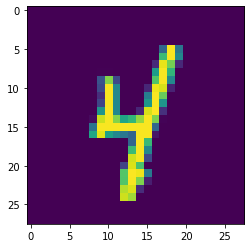

In [128]:
x, y = next(iter(ds_train))
plt.imshow(x[0,:,:,0])

**CNNs in TF Keras**

We'll use the Sequential class rely on new layer types that correspond to concepts we covered in lecture: Conv2D, AvgPool2D, MaxPool2D. 

Details such as kernel size, padding, strides and so on must be specified as args to these classes, where appropriate.

In [129]:
model = tfk.Sequential()
model.add(tfkl.Conv2D(filters = 256, kernel_size=(3,3), strides=(1,1), 
                      padding="valid", activation='relu', input_shape=(28, 28, 1)))
model.add(tfkl.MaxPool2D(pool_size=(4,4)))
model.add(tfkl.Flatten())
model.add(tfkl.Dense(10, activation='softmax'))

In [130]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 256)       2560      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                92170     
Total params: 94,730
Trainable params: 94,730
Non-trainable params: 0
_________________________________________________________________


In [131]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics=[tfk.metrics.CategoricalAccuracy()]
)

results = model.fit(ds_train, steps_per_epoch=50, epochs=10, validation_data=ds_test, validation_steps=1)

Epoch 1/10
50/50 [==============================] - 0s 9ms/step - loss: 0.9585 - categorical_accuracy: 0.7200 - val_loss: 0.4852 - val_categorical_accuracy: 0.8359
Epoch 2/10
50/50 [==============================] - 0s 7ms/step - loss: 0.4060 - categorical_accuracy: 0.8772 - val_loss: 0.2978 - val_categorical_accuracy: 0.9297
Epoch 3/10
50/50 [==============================] - 0s 7ms/step - loss: 0.2952 - categorical_accuracy: 0.9100 - val_loss: 0.1882 - val_categorical_accuracy: 0.9375
Epoch 4/10
50/50 [==============================] - 0s 7ms/step - loss: 0.2269 - categorical_accuracy: 0.9317 - val_loss: 0.1599 - val_categorical_accuracy: 0.9531
Epoch 5/10
50/50 [==============================] - 0s 7ms/step - loss: 0.1982 - categorical_accuracy: 0.9411 - val_loss: 0.1551 - val_categorical_accuracy: 0.9453
Epoch 6/10
50/50 [==============================] - 0s 7ms/step - loss: 0.1679 - categorical_accuracy: 0.9488 - val_loss: 0.1207 - val_categorical_accuracy: 0.9609
Epoch 7/10
50/50

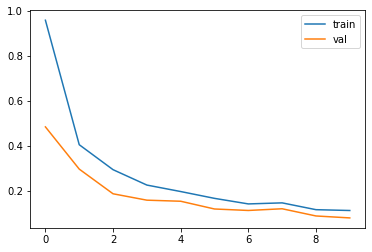

In [132]:
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["train", "val"])

Text(0.5, 0, 'Probability')

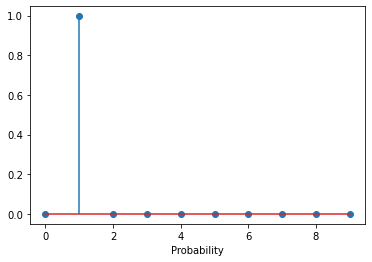

In [133]:
plt.stem(model.predict(ds_test.take(1))[9, :])
plt.xlabel("Digit")
plt.xlabel("Probability")

In [134]:
batch = next(iter(ds_test))

In [135]:
predict = model.predict(batch[0])
true = batch[1]


In [136]:
tf.argmax(batch[1],1) - tf.argmax(model.predict(batch[0]),1)

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)>

In [138]:
m.update_state(tf.argmax(model.predict(batch[0]),1),tf.argmax(batch[1],1))
m.result().numpy()

0.9756098

Which architectural hyperparameters might we change in the above?



**Exercise - Deep CNN**

Build and fit your own CNN model with 3 convolutional **modules**, where each one contains:
  * kernel convolution 
    * you pick number of kernels
    * you pick kernel shape/size
    * you pick activation
  * pooling
  * dropout

We'll use the Fashion MNIST dataset, a low-res collection of images of clothing.

In [141]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
images = images[:, :, :, np.newaxis]
labels = tf.one_hot(labels.astype(np.int32), depth=10)

# optional - TF Datasets objects
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).cache().batch(128).prefetch(10)

images, labels = test
images = images/255.0
images = images[:, :, :, np.newaxis]
labels = tf.one_hot(labels.astype(np.int32), depth=10)
fmnist_test_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_test_ds = fmnist_test_ds.shuffle(5000).batch(128)


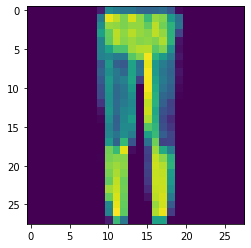

In [142]:
plt.imshow(images[3, :, :, :].squeeze())

In [143]:
model = tfk.Sequential()
# 1st conv module
model.add(tfkl.Conv2D(filters = 256, kernel_size=(2,2), strides=(1,1), 
                      padding="same", activation='relu', input_shape=(28, 28, 1)))
model.add(tfkl.MaxPool2D(pool_size=(2,2)))
model.add(tfkl.Dropout(0.25))

# 2nd conv module
model.add(tfkl.Conv2D(filters = 256, kernel_size=2, strides=(1,1), 
                      padding="same", activation='relu'))
model.add(tfkl.MaxPool2D(pool_size=(2,2)))
model.add(tfkl.Dropout(0.25))

# 3rd conv module
model.add(tfkl.Conv2D(filters = 256, kernel_size=(2,2), strides=(1,1), 
                      padding="valid", activation='relu'))
model.add(tfkl.MaxPool2D(pool_size=(2,2)))
model.add(tfkl.Dropout(0.25))

model.add(tfkl.Flatten())
model.add(tfkl.Dense(10, activation='softmax'))

In [144]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 256)       1280      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 256)       262400    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 256)        

In [145]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics=[tfk.metrics.CategoricalAccuracy()]
)

results = model.fit(fmnist_train_ds, steps_per_epoch=20, epochs=50, validation_data=fmnist_test_ds)

Epoch 1/50
20/20 [==============================] - 1s 45ms/step - loss: 1.7381 - categorical_accuracy: 0.3605 - val_loss: 1.1324 - val_categorical_accuracy: 0.6276
Epoch 2/50
20/20 [==============================] - 1s 39ms/step - loss: 0.9890 - categorical_accuracy: 0.6398 - val_loss: 0.8276 - val_categorical_accuracy: 0.6950
Epoch 3/50
20/20 [==============================] - 1s 39ms/step - loss: 0.8032 - categorical_accuracy: 0.7035 - val_loss: 0.7387 - val_categorical_accuracy: 0.7103
Epoch 4/50
20/20 [==============================] - 1s 39ms/step - loss: 0.6956 - categorical_accuracy: 0.7434 - val_loss: 0.6982 - val_categorical_accuracy: 0.7348
Epoch 5/50
20/20 [==============================] - 1s 40ms/step - loss: 0.6482 - categorical_accuracy: 0.7539 - val_loss: 0.6137 - val_categorical_accuracy: 0.7844
Epoch 6/50
20/20 [==============================] - 1s 39ms/step - loss: 0.5813 - categorical_accuracy: 0.7863 - val_loss: 0.5904 - val_categorical_accuracy: 0.7763
Epoch 7/50

 9/20 [============>.................] - 1s 81ms/step - loss: 0.3877 - categorical_accuracy: 0.8679 - val_loss: 0.3923 - val_categorical_accuracy: 0.8596


Text(0.5, 0, 'Probability')

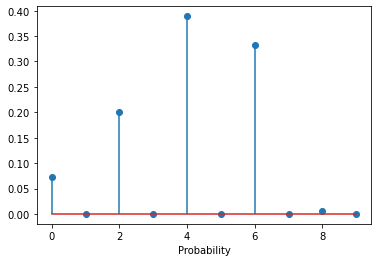

In [146]:
plt.stem(model.predict(fmnist_test_ds.take(1))[9, :])
plt.xlabel("Digit")
plt.xlabel("Probability")


#|**Exercise - Transfer Learning**



In [147]:
data = tfds.load('rock_paper_scissors')

In [172]:
train_data = data["train"].map(lambda x: (tf.cast(x["image"], tf.float32) / 255., tf.cast(tf.one_hot(x["label"],depth=3),tf.int32) )).cache().batch(16).repeat().prefetch(16)
test_data = data["test"].map(lambda x: (tf.cast(x["image"], tf.float32) / 255., tf.cast(tf.one_hot(x["label"],depth=3),tf.int32) )).cache().batch(16).repeat().prefetch(16)

In [173]:
tfds.as_dataframe(data["train"].take(10))

,image,label
0,[[[254 254 254] [253 253 253] [254 254 254] ... [251 251 251] [250 250 250] [250 250 250]] [[254 254 254] [254 254 254] [253 253 253] ... [250 250 250] [251 251 251] [249 249 249]] [[254 254 254] [254 254 254] [254 254 254] ... [251 251 251] [250 250 250] [252 252 252]] ... [[252 252 252] [251 251 251] [252 252 252] ... [247 247 247] [249 249 249] [248 248 248]] [[253 253 253] [253 253 253] [251 251 251] ... [248 248 248] [248 248 248] [248 248 248]] [[252 252 252] [253 253 253] [252 252 252] ... [248 248 248] [247 247 247] [250 250 250]]],2
1,[[[254 254 254] [253 253 253] [254 254 254] ... [252 252 252] [250 250 250] [250 250 250]] [[253 253 253] [255 255 255] [253 253 253] ... [251 251 251] [251 251 251] [250 250 250]] [[254 254 254] [253 253 253] [254 254 254] ... [252 252 252] [250 250 250] [251 251 251]] ... [[253 253 253] [252 252 252] [252 252 252] ... [249 249 249] [249 249 249] [250 250 250]] [[252 252 252] [252 252 252] [251 251 251] ... [248 248 248] [248 248 248] [249 249 249]] [[251 251 251] [252 252 252] [253 253 253] ... [248 248 248] [249 249 249] [250 250 250]]],2
2,[[[254 254 254] [253 253 253] [254 254 254] ... [241 241 241] [241 241 241] [240 240 240]] [[254 254 254] [253 253 253] [253 253 253] ... [238 238 238] [238 238 238] [242 242 242]] [[254 254 254] [253 253 253] [253 253 253] ... [240 240 240] [239 239 239] [238 238 238]] ... [[252 252 252] [250 250 250] [252 252 252] ... [250 250 250] [250 250 250] [250 250 250]] [[252 252 252] [252 252 252] [252 252 252] ... [248 248 248] [249 249 249] [249 249 249]] [[252 252 252] [252 252 252] [252 252 252] ... [248 248 248] [249 249 249] [250 250 250]]],0
3,[[[253 253 253] [253 253 253] [254 254 254] ... [242 242 242] [243 243 243] [243 243 243]] [[254 254 254] [253 253 253] [253 253 253] ... [241 241 241] [242 242 242] [242 242 242]] [[253 253 253] [254 254 254] [253 253 253] ... [241 241 241] [241 241 241] [241 241 241]] ... [[252 252 252] [250 250 250] [252 252 252] ... [250 250 250] [249 249 249] [250 250 250]] [[252 252 252] [252 252 252] [251 251 251] ... [248 248 248] [249 249 249] [249 249 249]] [[252 252 252] [252 252 252] [252 252 252] ... [248 248 248] [249 249 249] [251 251 251]]],1
4,[[[255 255 255] [255 255 255] [255 255 255] ... [255 255 255] [255 255 255] [255 255 255]] [[255 255 255] [255 255 255] [255 255 255] ... [255 255 255] [255 255 255] [255 255 255]] [[255 255 255] [255 255 255] [255 255 255] ... [255 255 255] [255 255 255] [255 255 255]] ... [[255 255 255] [255 255 255] [255 255 255] ... [254 254 254] [254 254 254] [254 254 254]] [[255 255 255] [255 255 255] [255 255 255] ... [254 254 254] [254 254 254] [254 254 254]] [[255 255 255] [255 255 255] [255 255 255] ... [254 254 254] [254 254 254] [254 254 254]]],0
5,[[[255 255 255] [255 255 255] [255 255 255] ... [255 255 255] [255 255 255] [255 255 255]] [[255 255 255] [255 255 255] [255 255 255] ... [255 255 255] [255 255 255] [255 255 255]] [[255 255 255] [254 254 254] [255 255 255] ... [255 255 255] [255 255 255] [255 255 255]] ... [[255 255 255] [255 255 255] [255 255 255] ... [254 254 254] [254 254 254] [254 254 254]] [[255 255 255] [255 255 255] [255 255 255] ... [254 254 254] [254 254 254] [254 254 254]] [[255 255 255] [255 255 255] [255 255 255] ... [254 254 254] [254 254 254] [254 254 254]]],1
6,[[[253 253 253] [253 253 253] [254 254 254] ... [242 242 242] [242 242 242] [241 241 241]] [[254 254 254] [253 253 253] [253 253 253] ... [241 241 241] [240 240 240] [242 242 242]] [[253 253 253] [253 253 253] [253 253 253] ... [241 241 241] [241 241 241] [238 238 238]] ... [[252 252 252] [251 251 251] [252 252 252] ... [250 250 250] [250 250 250] [250 250 250]] [[251 251 251] [253 253 253] [252 252 252] ... [249 249 249] [250 250 250] [250 250 250]] [[252 252 252] [252 252 252] [252 252 252] ... [249 249 249] [250 250 250] [251 251 251]]],2
7,[[[255 255 255] [255 255 255] [255 255 255] ... [255 255 255] [255 255 255] [255 255 255]] [[255 255 255] [255 255 255] [255 255 255] .

In [174]:
train_data

<PrefetchDataset shapes: ((None, 300, 300, 3), (None, 3)), types: (tf.float32, tf.int32)>

# Exercise

1. Build a deep CNN model and train it for this binary classification task. Fit the model using the small dataset of 500 samples, *train_data*.

What accuracy can your model acheive on the training data?

In [196]:
model = tfk.Sequential()
# 1st conv module
model.add(tfkl.Conv2D(filters = 256, kernel_size=(2,2), strides=(1,1), 
                      padding="same", activation='relu', input_shape=(300, 300, 3)))
model.add(tfkl.MaxPool2D(pool_size=(2,2)))
model.add(tfkl.Dropout(0.25))

# 2nd conv module
model.add(tfkl.Conv2D(filters = 128, kernel_size=2, strides=(1,1), 
                      padding="same", activation='relu'))
model.add(tfkl.MaxPool2D(pool_size=(2,2)))
model.add(tfkl.Dropout(0.25))

# 3rd conv module
model.add(tfkl.Conv2D(filters = 32, kernel_size=(2,2), strides=(1,1), 
                      padding="valid", activation='relu'))
model.add(tfkl.MaxPool2D(pool_size=(2,2)))
model.add(tfkl.Dropout(0.25))

model.add(tfkl.Flatten())
model.add(tfkl.Dense(50, activation='relu'))
model.add(tfkl.Dense(3, activation=tf.nn.softmax))


In [197]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 300, 300, 256)     3328      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 150, 150, 256)     0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 150, 150, 256)     0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 150, 150, 128)     131200    
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 75, 75, 128)       0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 75, 75, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 74, 74, 32)      

In [198]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics=[tfk.metrics.CategoricalAccuracy()]
)

results = model.fit(train_data, epochs=15, steps_per_epoch=32, validation_data=test_data, 
                    validation_steps=8)

Epoch 1/15
 2/32 [>.............................] - ETA: 3s - loss: 9.1093 - categorical_accuracy: 0.3438WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0520s vs `on_train_batch_end` time: 0.0901s). Check your callbacks.


32/32 [==============================] - 5s 147ms/step - loss: 1.6453 - categorical_accuracy: 0.3320 - val_loss: 1.0987 - val_categorical_accuracy: 0.3281
Epoch 2/15
32/32 [==============================] - 5s 144ms/step - loss: 1.2034 - categorical_accuracy: 0.4004 - val_loss: 1.0930 - val_categorical_accuracy: 0.3438
Epoch 3/15
32/32 [==============================] - 5s 144ms/step - loss: 1.0617 - categorical_accuracy: 0.5215 - val_loss: 1.0196 - val_categorical_accuracy: 0.5312
Epoch 4/15
32/32 [==============================] - 5s 144ms/step - loss: 0.7514 - categorical_accuracy: 0.6973 - val_loss: 0.9689 - val_categorical_accuracy: 0.4219
Epoch 5/15
32/32 [==============================] - 5s 142ms/step - loss: 0.3637 - categorical_accuracy: 0.8690 - val_loss: 0.5877 - val_categorical_accuracy: 0.7188
Epoch 6/15
32/32 [==============================] - 5s 145ms/step - loss: 0.1628 - categorical_accuracy: 0.9492 - val_loss: 0.5510 - val_categorical_accuracy: 0.7500
Epoch 7/15
32/3

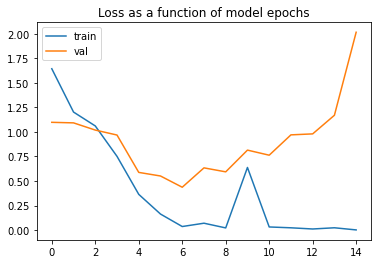

In [199]:
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["train", "val"])
plt.title("Loss as a function of model epochs")
plt.show()

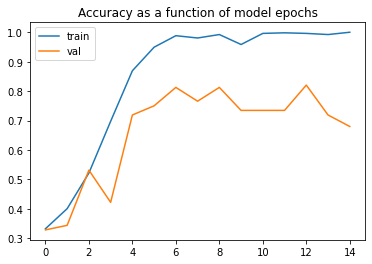

In [200]:
plt.plot(results.history["categorical_accuracy"])
plt.plot(results.history["val_categorical_accuracy"])
plt.legend(labels=["train", "val"])
plt.title("Accuracy as a function of model epochs")
plt.show()

 2. Now use transfer learning by incorporating the pretrained VGG16 model.

In [181]:
from tensorflow.keras.applications import VGG16

In [182]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(300,300,3))

In [183]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

Build a Sequential model, using our VGG16 base. Make sure the freeze the weights of the convolutional backbone, but leave the remainder of the network weights as learnable. Fit this model and compare the overall accuracy as well as the loss curves (efficiency).


In [184]:
model = tfk.Sequential()
model.add(conv_base)
model.layers[0].trainable = False

In [185]:
model.add(tfkl.Flatten())
model.add(tfkl.Dense(3, activation='softmax'))

In [186]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 41472)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 124419    
Total params: 14,839,107
Trainable params: 124,419
Non-trainable params: 14,714,688
_________________________________________________________________


In [188]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
    metrics=[tfk.metrics.CategoricalAccuracy()]
)

results = model.fit(train_data, steps_per_epoch=32, epochs=50, validation_data=test_data, validation_steps = 8)

Epoch 1/50
32/32 [==============================] - 3s 87ms/step - loss: 0.5227 - categorical_accuracy: 0.9746 - val_loss: 0.1858 - val_categorical_accuracy: 0.9141
Epoch 2/50
32/32 [==============================] - 3s 81ms/step - loss: 4.2186e-04 - categorical_accuracy: 1.0000 - val_loss: 0.2691 - val_categorical_accuracy: 0.8828
Epoch 3/50
32/32 [==============================] - 3s 81ms/step - loss: 0.2015 - categorical_accuracy: 0.9746 - val_loss: 0.2540 - val_categorical_accuracy: 0.9062
Epoch 4/50
32/32 [==============================] - 3s 81ms/step - loss: 2.1191e-04 - categorical_accuracy: 1.0000 - val_loss: 0.1781 - val_categorical_accuracy: 0.9219
Epoch 5/50
32/32 [==============================] - 3s 93ms/step - loss: 7.4387e-05 - categorical_accuracy: 1.0000 - val_loss: 0.4616 - val_categorical_accuracy: 0.8594
Epoch 6/50
32/32 [==============================] - 3s 82ms/step - loss: 0.1884 - categorical_accuracy: 0.9727 - val_loss: 0.4686 - val_categorical_accuracy: 0.875

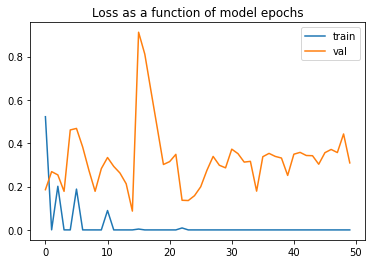

In [189]:
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["train", "val"])
plt.title("Loss as a function of model epochs")
plt.show()

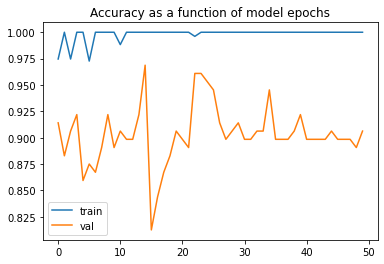

In [191]:
plt.plot(results.history["categorical_accuracy"])
plt.plot(results.history["val_categorical_accuracy"])
plt.legend(labels=["train", "val"])
plt.title("Accuracy as a function of model epochs")
plt.show()